# ASEN 6519 Fall 2018 - Midterm Project 
## Extended KF and Ensemble Filters with Lorenz-63

### The Lorenz-63 Model
Low-dimensional model: the state is made of 3 variables $x = (x1, x2, x3)$ and dynamical system evolution is given by the following equations:

$$\frac{\partial x_1}{\partial t} = -Ax_1 + Ax_2$$
$$\frac{\partial x_2}{\partial t} = Bx_1 - x_1x_3 - x_2$$
$$\frac{\partial x_3}{\partial t} = x_1x_2 - Cx_3$$

where $A=10$, $B=28$, and $C=8/3$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dfdt(r, coeffs):
    '''
    Returns dx1/dt, dx2/dt, dx3/dt
    '''
    # Current position
    x1 = r[0]
    x2 = r[1]
    x3 = r[2]
    
    # Extract coefficients
    A = coeffs[0]
    B = coeffs[1]
    C = coeffs[2]
    
    # Calculate the derivative
    dx1 = -A*x1 + A*x2
    dx2 = B*x1 - x1*x3 - x2
    dx3 = x1*x2 - C*x3
    
    return np.array([dx1, dx2, dx3], float)

### 1. Generate $true$ state and synthetic observations using Lorenz63 setup with the default inputs.

In [3]:
def advance_time(r, coeffs, h):
    '''
    Calculate the state of the system at time t+1 using RK2
    
    Inputs:
        r - the state
        coeffs - the standard Lorenz system coefficients
        h - timstep
    '''
    
    # Calculate Runge-Kutta2 coefficients
    k1 = h*dfdt(r, coeffs)
    k2 = h*dfdt(r+0.5*k1, coeffs)
    
    # Update current position
    r += k2
    
    return r

#### Setup Model

In [4]:
## Model setup  (Do not change)
N_state = 3 # Number of state variables
MO = 3      # Number of measurement variables

A_lor = 10  # Default Lorenz system parameters
B_lor = 28
C_lor = 8/3
coeffs = np.array([A_lor, B_lor, C_lor],float)

# Numerical parameters
t0 = 0          # sec, initial time
tf_assim = 3    # sec, final time   of forecast
tf_fore = 1     # sec, final length of forecast
h_sys = 0.01    # sec, timestep for system dynamics
dyn2meas = 20   # Number of dynamics updates per measurement
h_obs = h_sys * dyn2meas     # sec; an observation is generated every h_obs sec
t_sys = np.arange(t0,tf_assim,h_sys)     # time stamps for system dynamics
t_obs = np.arange(t0,tf_assim,h_obs)     # time stamps for observations
N_sys = len(t_sys)               # Number of system timesteps
N_obs = len(t_obs)               # Number of observations

## Initial conditions
x_true = np.zeros([N_state, N_sys])  # True history of x1 (without any noise)
x_s = np.zeros([N_state, N_sys])     # Noisy history of x1 (with process noise)
y = np.zeros([MO, N_obs])  # Measurements of x1 (with measurement noise)

# default input parameters, she uses 'astr' name
x1_0 = 1.5
x2_0 = -1.5
x3_0 = 25.5

#### Setup Errors/Covariances

In [5]:
## Background error variance
var_b = 0.1   
B_struct = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]])
B_cov = var_b * B_struct

# Note: dont have usehigh order scheme
# note forget about Q
## Model error covariance (ie: process noise), from Evensen 1997
Q = np.zeros((3,3))
Q[0,0] = 0.1491
Q[0,1] = 0.1505
Q[0,2] = 0.0007
Q[1,0] = 0.1505
Q[1,1] = 0.9048
Q[1,2] = 0.0014
Q[2,0] = 0.0007
Q[2,1] = 0.0014
Q[2,2] = 0.9180
# Qsqrt_cov = np.linalg.cholesky(Q)
L, V = np.linalg.eig(Q)
Qsqrt_cov = V*np.sqrt(L)    # TODO: Why this?

## Misc errors which I do not understand yet but need to run the system
varobs = 3   # Observation error variance
svar = 0.3

## Measurement covariance
sobs = np.sqrt(varobs)
R_struct = np.eye(3)
R = varobs * R_struct
L, V = np.linalg.eig(R)
Msqrt_cov = V*np.sqrt(L)

# ## Generate all the process noise ahead of time
# pnoise_seed = np.random.randn(MO, N_sys)
# pnoise = Qsqrt_cov @ pnoise_seed

#### Run the System: Generate States ($x_{true}$)

In [6]:
## Iterate through time and simulate dynamics
r = np.array([[x1_0, x2_0, x3_0]], float).T   # "Current" position

## Set ICs
x_true[:,0] = np.squeeze(r)
x_s[:,0] = np.squeeze(r + svar * np.random.randn(3,1))

for i in range(1,N_sys):
#     # Current time step (i)
#     x_true[:,i] = np.squeeze(r)
    
    # Advance time step (i+1)
    x_true[:,i] = advance_time(x_true[:,i-1], coeffs, h_sys)
    x_s[:,i] = advance_time(x_s[:,i-1], coeffs, h_sys) + \
                np.squeeze(Qsqrt_cov @ np.random.randn(3,1))

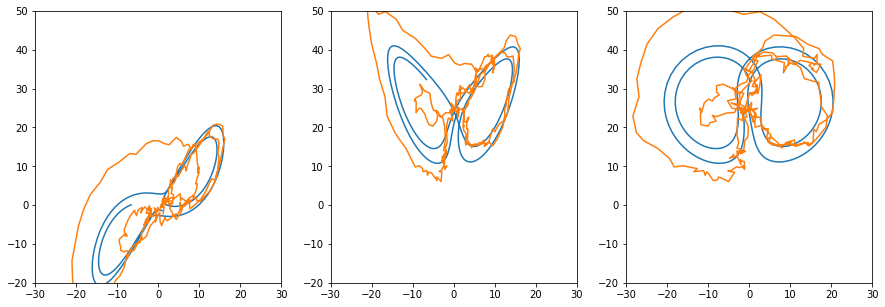

In [7]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1) ; plt.plot(x_true[0,:],x_true[1,:]);plt.ylim(-20,50);plt.xlim(-30,30)
plt.plot(x_s[0,:],x_s[1,:])

plt.subplot(1,3,2)
plt.plot(x_true[0,:],x_true[2,:]); plt.ylim(-20,50);plt.xlim(-30,30)
plt.plot(x_s[0,:],x_s[2,:]) 

plt.subplot(1,3,3) ; plt.plot(x_true[1,:],x_true[2,:]);plt.ylim(-20,50);plt.xlim(-30,30)
plt.plot(x_s[1,:],x_s[2,:])
plt.show()

#### Generate Measurements

In [8]:
for i in range(N_obs):
    # this reads in states from 0 to 300 in increments of 20 to get even spread of obseravations
    # [:,np.newaxis] makes dimensions from 3, to 3x1.
    curr_state = x_true[:,i*dyn2meas][:,np.newaxis]
    # for each state selected, obs = Measurement covariance + randomness
    y[:,i] = np.squeeze(curr_state + Msqrt_cov @ np.random.randn(3,1))

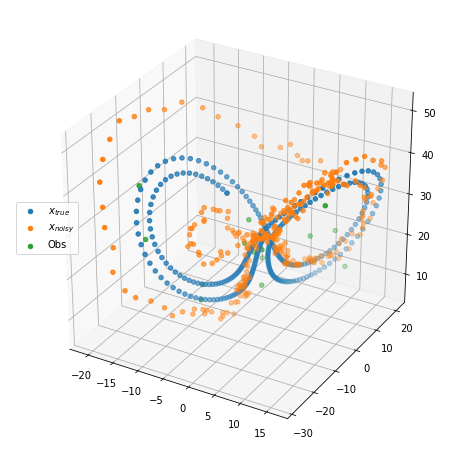

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_true[0,:],x_true[1,:],x_true[2,:],label='$x_{true}$')
ax.scatter(x_s[0,:],x_s[1,:],x_s[2,:],label='$x_{noisy}$')#,s=100,marker='x')
ax.scatter(y[0,:],y[1,:],y[2,:],label='Obs')#,s=100,marker='x')
ax.legend(loc=6)
plt.show()

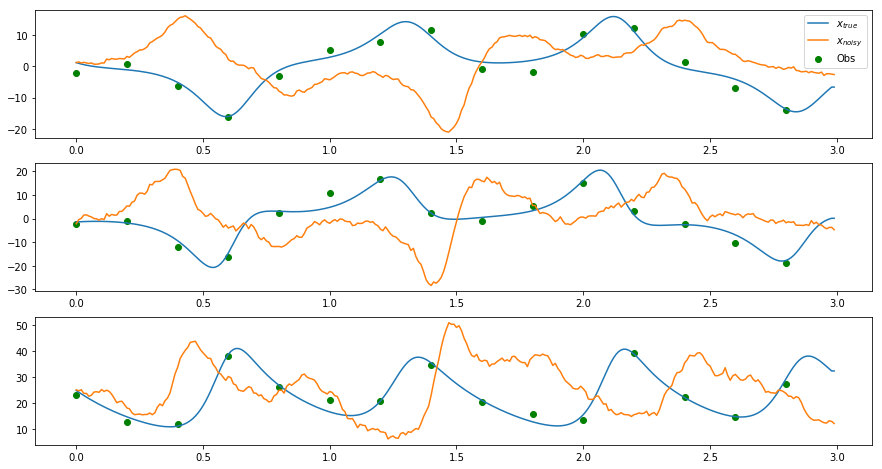

In [10]:
## Plot true state; state evolved with process noise; true state + measurement noise
plt.figure(figsize=[15,8])
plt.subplot(3,1,1) ; plt.plot(t_sys, x_true[0,:],label='$x_{true}$') ; plt.plot(t_sys, x_s[0,:],label='$x_{noisy}$') ; plt.scatter(t_obs, y[0,:],color='green',label='Obs')
plt.legend()
plt.subplot(3,1,2) ; plt.plot(t_sys, x_true[1,:]) ; plt.plot(t_sys, x_s[1,:]) ; plt.scatter(t_obs, y[1,:],color='green')
plt.subplot(3,1,3) ; plt.plot(t_sys, x_true[2,:]) ; plt.plot(t_sys, x_s[2,:]) ; plt.scatter(t_obs, y[2,:],color='green')
plt.show()

### 2. Implement your own EKF to estimate $x_a$. The tangent linear and adjoint codes are provided.
 - Investigate the performance of filter in terms of the bias and mean-square-error of data assimilation analysis. How does the estimate-error computed from $x_a$ and the truth value of $x$ compare to the error variance suggested by the posterior covariance?
 - Examine the sensitivity of the filter performance to the errors in the background. (Compare at least 10 cases)
 - Examine the sensitivity of the filter performance to the accuracy and frequency of observations. Is it better to have frequent but inaccurate observations or infrequent but accurate ones? (Compare at least $10\times 10$ cases.)
 
 **EKF Algorithm** (Lecture 6, Slide 9)
 * Note
     * $M_{nl}$ and $H_nl$ are the true nonlinear forward model and observation models, and $M$ and $H$ are the tangent linear models of the nonlinear operators 
     * where $M_t = \frac{\delta M_{nl}}{\delta x}$, evaluated at $x = x^a_{t-1}$
     * Our $H$ is linear for this problem
 * *Forecast* 
     * $x^f_t = M_{nl}(x^a_{t-1})$
     * $P^f_t = M_{t} P^a_{t-1} M^T_t + Q_t$
 * *Update*
     * $x^a_t = x^f_t + K_t (y_t - H_{nl}(x^f_t)$
     * $P^a_t = (I - K_t H_t) P^f_t$
     * where $K_t = P^f_t H^T_t(R_t + H_t P^f_t H^T_t)^{-1}$

In [11]:

# ## Set up necessary matrixies
# H = np.eye(3)
# I = np.eye(3)
# y_mat = np.matrix(y)

# ## ICs for the EKF
# xa = np.array([[y[0,0], y[1,0], y[2,0]]], float).T
# Pa = B_cov

# ## Store histories
# xf_EKF = np.matrix(np.zeros([3, 15]))
# Pf_EKF = np.zeros(shape=[3,3,15])
# xa_EKF = np.matrix(np.zeros([3, 15]))
# Pa_EKF = np.zeros(shape=[3,3,15])

# xf_EKF[:,0] = y_mat[:,0]
# Pf_EKF[:,:,0] = Pa
# xa_EKF[:,0] = y_mat[:,0]
# Pa_EKF[:,:,0] = Pa

# ## Run the EKF
# for i in range(1,N_obs):
#     ## Unpack values for this timestep
#     x1, x2, x3 = xa[0,0], xa[1,0], xa[2,0]
#     y_t = np.asarray(y_mat[:,i])
    
#     ## Forecast
#     xf = advance_time(xa, coeffs, h_obs) # Forecast mean
#     M = np.array([          # The tangent linear model evaluated at x=xa
#         [-A_lor  ,  A_lor  ,  0.0],
#         [B_lor-x3, -1.0,  -x1],
#         [x2  , x1  ,  -C_lor]])
#     Pf = M @ Pa @ M.T + Q  # Forecast covar
#     xf_EKF[:,i], Pf_EKF[:,:,i] = xf, Pf  # Store forecast
    
#     ## Update
#     K = Pf @ H.T @ np.linalg.inv(R + H@Pf@H.T)  # Kalman gain
#     xa = xf + K @ (y_t - H @ xf)   # Update mean
#     Pa = (I - K @ H) @ Pf   # Update covar
#     xa_EKF[:,i], Pa_EKF[:,:,i] = xa, Pa  # Store update



In [12]:
# ## Set up necessary matrixies
# H = np.eye(3)
# I = np.eye(3)
# y_mat = np.matrix(y)

# ## Store histories
# xf_EKF = np.matrix(np.zeros([3, N_sys]))
# Pf_EKF = np.zeros(shape=[3,3,N_sys])
# xa_EKF = np.matrix(np.zeros([3, N_sys]))
# Pa_EKF = np.zeros(shape=[3,3,N_sys])

# ## ICs for the EKF
# xa = np.array([[y[0,0], y[1,0], y[2,0]]], float).T
# Pa = B_cov.copy()
# Pf = B_cov.copy()

# xf_EKF[:,0] = y_mat[:,0].copy()
# Pf_EKF[:,:,0] = Pa.copy()
# xa_EKF[:,0] = y_mat[:,0].copy()
# Pa_EKF[:,:,0] = Pa.copy()


# ## Run the EKF
# for i in range(0,3):
#     ## Run the dynamics forward to the next measurement
#     for j in range(1,dyn2meas):   
#         xf = advance_time(xa, coeffs, h_sys)  # Forecast to next time step
#         xa = xf                               # Update current step to the forecast for this step
#         xf_EKF[:,i*dyn2meas+j], Pf_EKF[:,:,i*dyn2meas+j] = xf.copy(), Pf.copy()
#         xa_EKF[:,i*dyn2meas+j], Pa_EKF[:,:,i*dyn2meas+j] = xa.copy(), Pf.copy()  # Intentionally set a to forecast vals for now
        
#     #### Run the EKF now
#     ## Unpack values for this timestep
#     x1, x2, x3 = xa[0,0], xa[1,0], xa[2,0]
#     y_t = np.asarray(y_mat[:,i])  
    
#     ## Forecast
#     xf = advance_time(xa, coeffs, h_sys) # Forecast mean
#     M = np.array([          # The tangent linear model evaluated at x=xa
#         [-A_lor  ,  A_lor  ,  0.0],
#         [B_lor-x3, -1.0,  -x1],
#         [x2  , x1  ,  -C_lor]])
#     Pf = M @ Pa @ M.T + Q  # Forecast covar
#     xf_EKF[:,i], Pf_EKF[:,:,i] = xf.copy(), Pf.copy()  # Store forecast
    
#     ## Update
#     K = Pf @ H.T @ np.linalg.inv(R + H@Pf@H.T)  # Kalman gain
#     xa = xf + K @ (y_t - H @ xf)   # Update mean
#     Pa = (I - K @ H) @ Pf   # Update covar
#     xa_EKF[:,i], Pa_EKF[:,:,i] = xa.copy(), Pa.copy()  # Store update

In [13]:
## Set up necessary matrixies
H = np.eye(3)
I = np.eye(3)
y_mat = np.matrix(y)

## Store histories
xf_EKF = np.matrix(np.zeros([3, N_sys]))
Pf_EKF = np.zeros(shape=[3,3,N_sys])
xa_EKF = np.matrix(np.zeros([3, N_obs]))
Pa_EKF = np.zeros(shape=[3,3, N_obs])

## ICs for the EKF
xa = np.array([[y[0,0], y[1,0], y[2,0]]], float).T
Pa = B_cov.copy()
Pf = B_cov.copy()

xf_EKF[:,0] = y_mat[:,0].copy()
Pf_EKF[:,:,0] = Pa.copy()
xa_EKF[:,0] = y_mat[:,0].copy()
Pa_EKF[:,:,0] = Pa.copy()

## Run the EKF
for i in range(0,N_obs-1):
    ## Run the dynamics forward right up to the next measurement
    for j in range(1,dyn2meas):   
        xf = advance_time(xa, coeffs, h_sys)  # Forecast to next time step
#         xa = xf                               # Update current step to the forecast for this step
        xf_EKF[:,i*dyn2meas+j], Pf_EKF[:,:,i*dyn2meas+j] = xf.copy(), Pf.copy()
#         xa_EKF[:,i*dyn2meas+j], Pa_EKF[:,:,i*dyn2meas+j] = xa.copy(), Pf.copy()  # Intentionally set a to forecast vals for now
        
    #### Run the EKF now
    ## Unpack values for this timestep
    x1, x2, x3 = xa[0,0], xa[1,0], xa[2,0]
    y_t = np.asarray(y_mat[:,i+1])
    M = np.array([          # The tangent linear model evaluated at x=xa
        [-A_lor  ,  A_lor  ,  0.0],
        [B_lor-x3, -1.0,  -x1],
        [x2  , x1  ,  -C_lor]])
    
    ## Forecast
    xf = advance_time(xa, coeffs, h_sys) # Forecast mean
    Pf = M @ Pa @ M.T + Q  # Forecast covar
    xf_EKF[:,(i+1)*dyn2meas], Pf_EKF[:,:,(i+1)*dyn2meas] = xf.copy(), Pf.copy()  # Store forecast
    
    ## Update
    K = Pf @ H.T @ np.linalg.inv(R + H@Pf@H.T)  # Kalman gain
    xa = xf + K @ (y_t - H @ xf)   # Update mean
    Pa = (I - K @ H) @ Pf   # Update covar
    xa_EKF[:,i+1], Pa_EKF[:,:,i+1] = xa.copy(), Pa.copy()  # Store update

In [14]:
Pa_EKF[0,0,:]

array([0.1       , 2.33771478, 2.91831076, 2.97886346, 2.90514362,
       2.77681127, 2.98411806, 2.9768668 , 2.91750537, 2.93485237,
       2.7679912 , 2.96811019, 2.95617321, 2.90912259, 2.98346423])

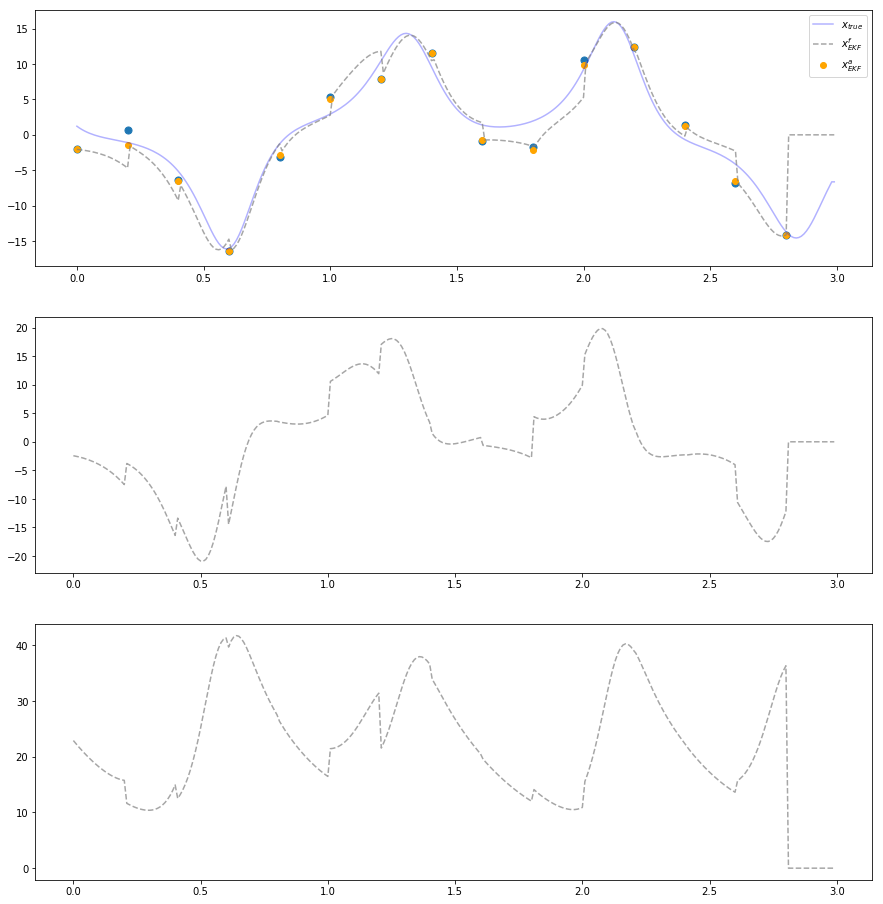

In [15]:
## Plot EKF analysis
plt.figure(figsize=[15,16])

## Plot x1
plt.subplot(3,1,1) ; plt.plot(t_sys, x_true[0,:], color='blue', label='$x_{true}$', alpha=0.3) ; plt.scatter(t_obs, y[0,:], s=50)
plt.plot(t_sys, np.ravel(xf_EKF[0,:]),color='grey',label='$x^f_{EKF}$', ls='--', alpha=0.7)
plt.scatter(t_obs, np.ravel(xa_EKF[0,:]),color='orange',label='$x^a_{EKF}$')
# plt.plot(t_sys, np.ravel(xa_EKF[0,:] + Pa_EKF[1,1,:]),color='orange',label='$x^a_{EKF}$')
# plt.plot(t_sys, np.ravel(x_true[0,:]) - np.ravel(xa_EKF[0,:] - 16),color='green', alpha=0.3, label='Residual', ls='--')
# plt.plot(t_sys, np.ones_like(t_sys)*16,color='green', alpha=0.3)
plt.legend()

# ## Plot x2
plt.subplot(3,1,2)
# plt.subplot(3,1,2) ; plt.plot(t_sys, x_true[1,:], color='blue', label='$x_{true}$', alpha=0.3) ; plt.scatter(t_obs, y[1,:], s=50)
plt.plot(t_sys, np.ravel(xf_EKF[1,:]),color='grey',label='$x^f_{EKF}$', ls='--', alpha=0.7)
# plt.plot(t_sys, np.ravel(xa_EKF[1,:]),color='orange',label='$x^a_{EKF}$')
# plt.legend()

## Plot x3
plt.subplot(3,1,3)
# plt.subplot(3,1,3) ; plt.plot(t_sys, x_true[2,:], color='blue', label='$x_{true}$', alpha=0.3) ; plt.scatter(t_obs, y[2,:], s=50)
plt.plot(t_sys, np.ravel(xf_EKF[2,:]),color='grey',label='$x^f_{EKF}$', ls='--', alpha=0.7)
# plt.plot(t_sys, np.ravel(xa_EKF[2,:]),color='orange',label='$x^a_{EKF}$')
# plt.legend()

plt.show()

### 3. Implement your own EnKF (with perturb observations) or EnSRF to estimate $x_a$.
 - Initialize the ensemble by introducing small perturbations to the state and integrating the model until its error growth saturates.
 - Compare the performance of the ensemble method to EKF with respect to each sub-question above. Launch ensemble forecasts (instead of deterministic forecasts) at the end of the assimilation period.
 - Evaluate the ensemble by using rank histograms.
 - Examine the impact of increasing or decreasing ensemble size on the filter performance as well as the forecast performance.

 **Stochastic EnKF Algorithm** (Katzfuss 2016)
 * Start with an initial ensemble $\hat x_0^{(1)}, ..., \hat x_0^{(N)}$
 * Then at each time $t = 1, 2, ...$, given an ensemble $\hat x_{t-1}^{(1)}, ..., \hat x_{t-1}^{(N)}$ of draws from the filtering (posterior) distribution at time $t-1$ the stochastic EnKF carries out the following two steps for $i = 1, ..., N$.
 * *Forecast* — Draw process noise $w_t^{(i)} \sim N_n(0, Q_t)$ and calculate $\widetilde{x}_t^{(i)} = M_t \hat x_{t-1}^{(i)} + w_t^{(i)}$
 * *Update* — Draw sensor noise $v_t^{(i)} \sim N_{m_t} (0, R_t)$ and calculate $\hat x_t^{(i)} = \widetilde{x}_t^{(i)} + \hat K_t(y_t - \widetilde{y}_t^{(i)} )$
     * where $y_t$ is the actual observation
     * and $\widetilde{y}_t^{(i)} = H_t \widetilde{x}_t^{(i)} - v_t^{(i)}$  is the simulated observation
     * and where $\hat K_t = C_tH_t^T(H_tC_tH_t^T + R_t)^{-1}$
     * and $C_t$ is an estimate of the state forecast covariance matrix $\widetilde{\Sigma}_t$. The simplest example is $C_t = \widetilde{S}_t$, where $\widetilde{S}_t$ is the sample covariance matrix of $\widetilde{x}_t^{(1)}, ..., \widetilde{x}_t^{(N)}$


In [16]:
## Generate initial ensemble
N_ens = 23   # number of ensemble members
xtld_hist = np.zeros((3, N_ens, N_obs))  # History of forecasts (x tilde)
xhat_hist = np.zeros((3, N_ens, N_obs))  # History of updated x's (x hat)
muw = np.zeros(3)   # the mean of process noise
mvw = np.zeros(3)   # the mean of sensor noise
Qh0 = Q               # initlal Q
w0 = np.random.multivariate_normal(muw, Qh0, size=N_ens).T  # Perturbations for the IC
x0_pure = np.array([[y[0,0], y[1,0], y[2,0]]]).T   # Unperturbed IC
xh0 = x0_pure + w0 # Initial position of ensemble members
xhat_hist[:,:,0] = xh0
xtld_hist[:,:,0] = xh0


## Move through time
for i in range(1,N_obs):
    if i not in obs_increments:
        wt = np.random.multivariate_normal(muw, Q, size=N_ens).T  # Draw process noise
        prev_update = xhat_hist[:,:,i-1].copy()
        xtld = advance_time(prev_update, coeffs, h_obs) + wt
        xtld_hist[:,:,i] = xtld        
        
    else:
        ## Forecast
        wt = np.random.multivariate_normal(muw, Q, size=N_ens).T  # Draw process noise
        prev_update = xhat_hist[:,:,i-1].copy()
        xtld = advance_time(prev_update, coeffs, h_obs) + wt
        xtld_hist[:,:,i] = xtld

        ## Update
        Ct = np.cov(xtld)    # Calculate sample covariance
        Kt = Ct @ H.T @ np.linalg.inv(H @ Ct @ H + R)  # Calculate Kalman gain
        vt = np.random.multivariate_normal(mvw, R, size=N_ens).T  # Draw measurement noise
        ytld = H@xtld - vt    # Calculate simulated observations
        yact = y[:,i][:,np.newaxis]  # Actual observation
        xhat = xtld + Kt @ (yact - ytld)
        xhat_hist[:,:,i] = xhat

NameError: name 'obs_increments' is not defined

In [ ]:
## Plot true state; true state + measurement noise; EnKF update predictions
plt.figure(figsize=[15,16])

## Plot x1
plt.subplot(3,1,1) ; plt.plot(t_sys, x_true[0,:], linewidth=3, color='k') ; plt.scatter(t_obs, y[0,:], s=50)
# plt.plot(t_obs, xtld_hist[0,3,:], alpha=0.3, label='Forecast - Ens Member 3')
# plt.plot(t_obs, xhat_hist[0,3,:], label='Update - Ens Member 3')
for i in range(N_ens):
    plt.plot(t_obs, xhat_hist[0,i,:], alpha=0.3)
plt.ylabel('x1')

## Plot x2
plt.subplot(3,1,2) ; plt.plot(t_sys, x_true[1,:], linewidth=3, color='k') ; plt.scatter(t_obs, y[1,:], s=50)
for i in range(N_ens):
    plt.plot(t_obs, xhat_hist[1,i,:], alpha=0.3)
plt.ylabel('x2')

## Plot x3
plt.subplot(3,1,3) ; plt.plot(t_sys, x_true[2,:], linewidth=3, color='k') ; plt.scatter(t_obs, y[2,:], s=50)
for i in range(N_ens):
    plt.plot(t_obs, xhat_hist[2,i,:], alpha=0.3)
plt.ylabel('x3')


# for i in range(N_ens):
#     plt.scatter(t_obs, xh_hist[0,i,:])
# plt.subplot(3,1,2) ; plt.plot(t_sys, x_true[1,:]) ; plt.scatter(t_obs, y[1,:])
# plt.subplot(3,1,3) ; plt.plot(t_sys, x_true[2,:]) ; plt.scatter(t_obs, y[2,:])
plt.show()